# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod

## 1. Implement $\epsilon$-Greedy and UCB

Reasons to change this super class
* Usage of ABC may cause the problem of multiple inheritance, and it will be redundant in the subclasses (which requires an extra slot in ```cls.__mro__```), meta-class is a better choice
* I decided to put one of the initialisation (the ```self.narms``` attribute) into the super class since all subclasses require this
* Usage of ```cls.__slots__``` forbids creation of ```cls.__dict__```, which will allow fast access of members and make the storage of object more compact and also avoid potential typos of attribute names

In [2]:
class MAB(metaclass=ABCMeta):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    __slots__ = "narms"
    
    def __init__(self, narms):
        self.narms = narms
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        
    # This method is re-used in all subclasses
    @staticmethod
    def _choose(values):
        return np.random.choice(
            # recognise ties
            np.argwhere(values == values.max()).flatten()
        )

### $\epsilon$-Greedy

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    __slots__ = "counts", "epsilon", "Q0", "rewards"
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        super().__init__(narms)
        self.epsilon = epsilon
        self.Q0 = Q0
        self.counts = np.zeros(narms, np.uint64)
        self.rewards = np.zeros(narms, np.float64)
        
    def play(self, tround, context=None):
        if np.random.random() > self.epsilon:
            # initialise an array of Q0
            values = np.full(self.narms, self.Q0, np.float64)
            counts = self.counts
            # determine all arms which has ever been selected before
            selected = (counts > 0).nonzero()
            # compute Q
            values[selected] = self.rewards[selected] / counts[selected]
            return self._choose(values)
        
        # a random play is made
        return np.random.randint(0, self.narms)
        
    def update(self, arm, reward, context=None):
        self.counts[arm] += 1
        self.rewards[arm] += reward

### UCB

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    __slots__ = "counts", "Q0", "rewards", "rho"
    
    def __init__(self, narms, rho, Q0=np.inf):
        super().__init__(narms)
        self.rho = rho
        self.Q0 = Q0
        self.counts = np.zeros(narms, np.uint64)
        self.rewards = np.zeros(narms, np.float64)
    
    def play(self, tround, context=None):
        # as above
        values = np.full(self.narms, self.Q0, np.float64)
        counts = self.counts
        selected = (counts > 0).nonzero()
        sc = counts[selected]
        # apply the formula
        values[selected] = self.rewards[selected] / sc + np.sqrt(self.rho * np.log(tround) / sc)
        return self._choose(values)
        
    def update(self, arm, reward, context=None):
        self.counts[arm] += 1
        self.rewards[arm] += reward

## 2. Off-Policy Evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    R = np.zeros(nrounds, np.float64)
    
    # use iterator for fast iteration
    itarm = iter(arms)
    itreward = iter(rewards)
    itcontexts = iter(contexts)
    for tround in range(nrounds):
        arm, reward, context = next(itarm), next(itreward), next(itcontexts)
        
        # find matching play
        while mab.play(tround + 1, context) + 1 != arm:
            arm, reward, context = next(itarm), next(itreward), next(itcontexts)
        
        # perform update
        mab.update(arm - 1, reward, context)
        R[tround] += reward
    
    return R

### Read file

In [6]:
txt = np.loadtxt("dataset.txt", np.int64)
arms, rewards, contexts = txt[:, 0], txt[:, 1], txt[:, 2:]

### Evaluation

In [7]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', results_EpsGreedy.mean())

EpsGreedy average reward 0.265


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', results_UCB.mean())

UCB average reward 0.1775


## 3. Contextual Bandits

In [8]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    __slots__ = "alpha", "As", "bs", "ndims"
    
    def __init__(self, narms, ndims, alpha):
        super().__init__(narms)
        self.ndims = ndims
        self.alpha = alpha
        self.As = [np.eye(ndims) for _ in range(narms)]
        self.bs = [np.zeros(ndims) for _ in range(narms)]
        
    def play(self, tround, context):
        return self._choose(np.fromiter((
            Ai.dot(b).dot(x) + self.alpha * np.sqrt(x.T.dot(Ai).dot(x))
            for x, Ai, b in zip(
                # reshape the context to (narms, ndims)
                context.reshape(self.narms, self.ndims),
                # we only use the inverse of the matrix in the computation
                map(inv, self.As),
                self.bs
            )
        ), np.float64))
    
    def update(self, arm, reward, context):
        ndims = self.ndims
        start = arm * ndims
        # extract the segment of features of the specific arm
        context = context[start:start + ndims]
        self.bs[arm] += reward * context
        # context is an array so reshape it to a 1d vector
        context = context.reshape(1, ndims)
        # perform matrix multiplication, same effect as np.dot
        self.As[arm] += context.T.dot(context)

### Evaluation

In [10]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', results_LinUCB.mean())

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

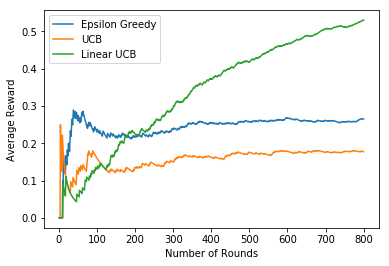

In [11]:
# T starts from 1
xaxis = np.arange(1, 801)
ax = plt.figure().subplots()
ax.plot(xaxis, results_EpsGreedy.cumsum() / xaxis)
ax.plot(xaxis, results_UCB.cumsum() / xaxis)
ax.plot(xaxis, results_LinUCB.cumsum() / xaxis)
ax.legend(labels=("Epsilon Greedy", "UCB", "Linear UCB"))
ax.set_xlabel("Number of Rounds")
ax.set_ylabel("Average Reward")
plt.show()

### 4.B.

In [12]:
alphas = np.linspace(0, 10, 101, dtype=np.float64)


def _eval(alpha):
    # avoid potential overhead of lambda function
    return offlineEvaluate(LinUCB(10, 10, alpha), arms, rewards, contexts, 800).mean()


scores = np.vectorize(_eval)(alphas)

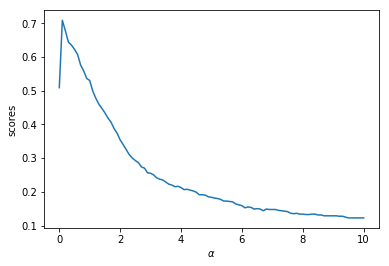

In [13]:
ax = plt.figure().subplots()
ax.plot(alphas, scores)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("scores")
plt.show()

In [14]:
maxpos = (scores == scores.max()).nonzero()
print(scores[maxpos])
print(alphas[maxpos])

[0.70875]
[0.1]


## 5. KernelUCB

In [18]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [16]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    
    __slots__ = "ndims", "gamma", "eta", "kern", "Ki", "xts", "ys"
    
    def __init__(self, narms, ndims, gamma, eta, kern):
        super().__init__(narms)
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.Ki = None
        self.xts = []
        self.ys = []
        
    def _compute(self, x, t):
        Ki = self.Ki
        # re-usable values
        kxt = self.kern(x, self.xts)
        kxtKi = kxt.dot(Ki)
        return kxtKi.dot(self.ys) + self.eta * np.sqrt(
            (self.kern(x, x) - kxtKi.dot(kxt.T)) / self.gamma
        )
    
    def play(self, tround, context):
        # first round always return the first arm
        if tround == 1:
            return 0
        
        ndims = self.ndims
        return self._choose(
            np.fromiter(
                (
                    # reshape the x vector for computation
                    self._compute(x.reshape(1, ndims), tround)
                    # reshape context to obtain a (narms, ndims) matrix
                    for x in context.reshape(self.narms, ndims)
                ),
                np.float64
            )
        )
    
    def update(self, arm, reward, context):
        gamma = self.gamma
        kern = self.kern
        Ki = self.Ki
        ndims = self.ndims
        xts = self.xts
        start = arm * ndims
        _x = context[start:start + ndims]
        # reshape to a (1, ndims) vector for computation
        x = _x.reshape(1, ndims)
        xkern = kern(x, x)
        if Ki is None:
            # initialise kernel matrix inverse
            self.Ki = inv(xkern + gamma)
        else:
            # compute all re-usable values
            kxt = kern(x, xts)
            kxtT = kxt.T
            kxtKi = kxt.dot(Ki)
            KikxtT = Ki.dot(kxtT)
            # multiplicative associativity, ABC = A(BC) => ABCD = (AB)(CD)
            K22 = 1 / (xkern + gamma - kxtKi.dot(kxtT))
            K11 = Ki + K22 * KikxtT.dot(kxtKi)
            K12 = -K22 * KikxtT
            K21 = -K22 * kxtKi
            
            # perform blocking
            self.Ki = np.block([[K11, K12], [K21, K22]])
        
        xts.append(_x)
        self.ys.append(reward)

### Evaluation

In [19]:
mab = KernelUCB(10, 10, 0.5, 1.0, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', results_KernelUCB.mean())

KernelUCB average reward 0.38625


### Grid Search

In [ ]:
gammas = np.linspace(0.1, 1, 10, dtype=np.float64)
etas = np.linspace(0, 1, 11, dtype=np.float64)

_gammas, _etas = np.meshgrid(gammas, etas)


def _eval(gamma, eta):
    # avoid potential overhead of lambda function
    return offlineEvaluate(KernelUCB(10, 10, gamma, eta, rbf_kernel), arms, rewards, contexts, 800).mean()


scores = np.vectorize(_eval)(_gammas, _etas)

In [ ]:
ax = plt.figure().subplots()

try:
    import seaborn as sns

    sns.heatmap(scores, xticklabels=np.arange(11) / 10, yticklabels=np.arange(1, 11) / 10)
except ImportError:
    ax.imshow(scores)
    ax.set_xticklabels(np.arange(-2, 11, 2) / 10)
    ax.set_yticklabels(np.arange(-1, 10, 2) / 10)

ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\gamma$")
plt.show()

In [ ]:
maxpos = np.nonzero(scores == scores.max())
print(scores[maxpos])
print(_gammas[maxpos])
print(_etas[maxpos])